### **Problem definition:**
We want to analyze Covid-19 policies relative to the number of cases in six countries from the Balkan peninsula and we want to compare how the different countries from the region handled the crisis and we want to extract potential insights. We have chosen these countries due to the relativy close stage in economic development and sanitetion levels. Namely, the counries of interest are: 'Bulgaria','Greece','Serbia','Bosnia and Herzegovina','Romania' and 'Albania'.

To solve this problem, we will make use of the famous Oxford covid policy tracker dataset - OxCGRT.

In [ ]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import matplotlib.colors as mcolors

import math
import random
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from sklearn.decomposition import PCA
from statsmodels.graphics.factorplots import interaction_plot

plt.style.use('ggplot')

### Importing and review dataset


In [ ]:
data = pd.read_csv('/content/OxCGRT_newest.csv',delimiter = ",")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110662 entries, 0 to 110661
Data columns (total 61 columns):
 #   Column                                                                           Non-Null Count   Dtype  
---  ------                                                                           --------------   -----  
 0   CountryName                                                                      110662 non-null  object 
 1   CountryCode                                                                      110662 non-null  object 
 2   RegionName                                                                       65012 non-null   object 
 3   RegionCode                                                                       65012 non-null   object 
 4   Jurisdiction                                                                     110662 non-null  object 
 5   Date                                                                             110662 non-null  int64  
 

<ipython-input-2-db2ffca12a2f>:1: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/OxCGRT_newest.csv',delimiter = ",")


### **Total number of countries in the dataset:**

In [ ]:
print('The total number of countries in the data is: ',len(data['CountryName'].unique()))

The total number of countries in the data is:  54


### **Select the desired countries from the Balkan region:**

In [ ]:
#extract the countries of interest
countries = ['Bulgaria','Greece','Serbia',
             'Bosnia and Herzegovina','Romania','Albania']

countries.sort()

data = data[data['CountryName'].isin(countries)]

### **missing values:**

Text(0.5, 1.0, 'Datatypes summary')

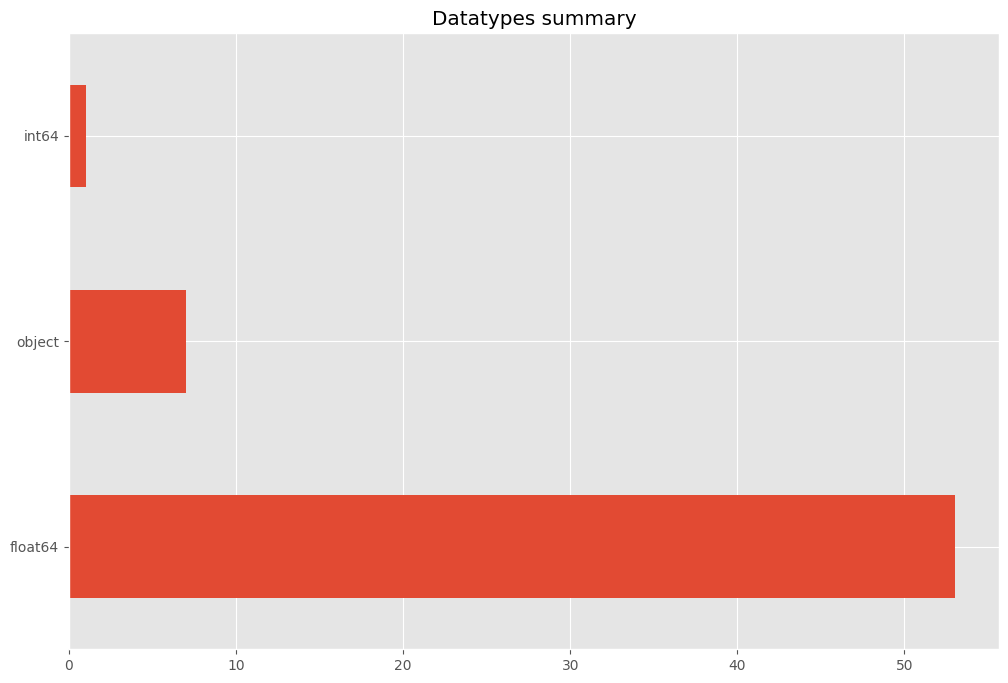

In [ ]:
plt.figure(figsize = (12, 8))
data.dtypes.value_counts().plot(kind='barh')
plt.title("Datatypes summary")

Text(0.5, 1.0, 'Missing values')

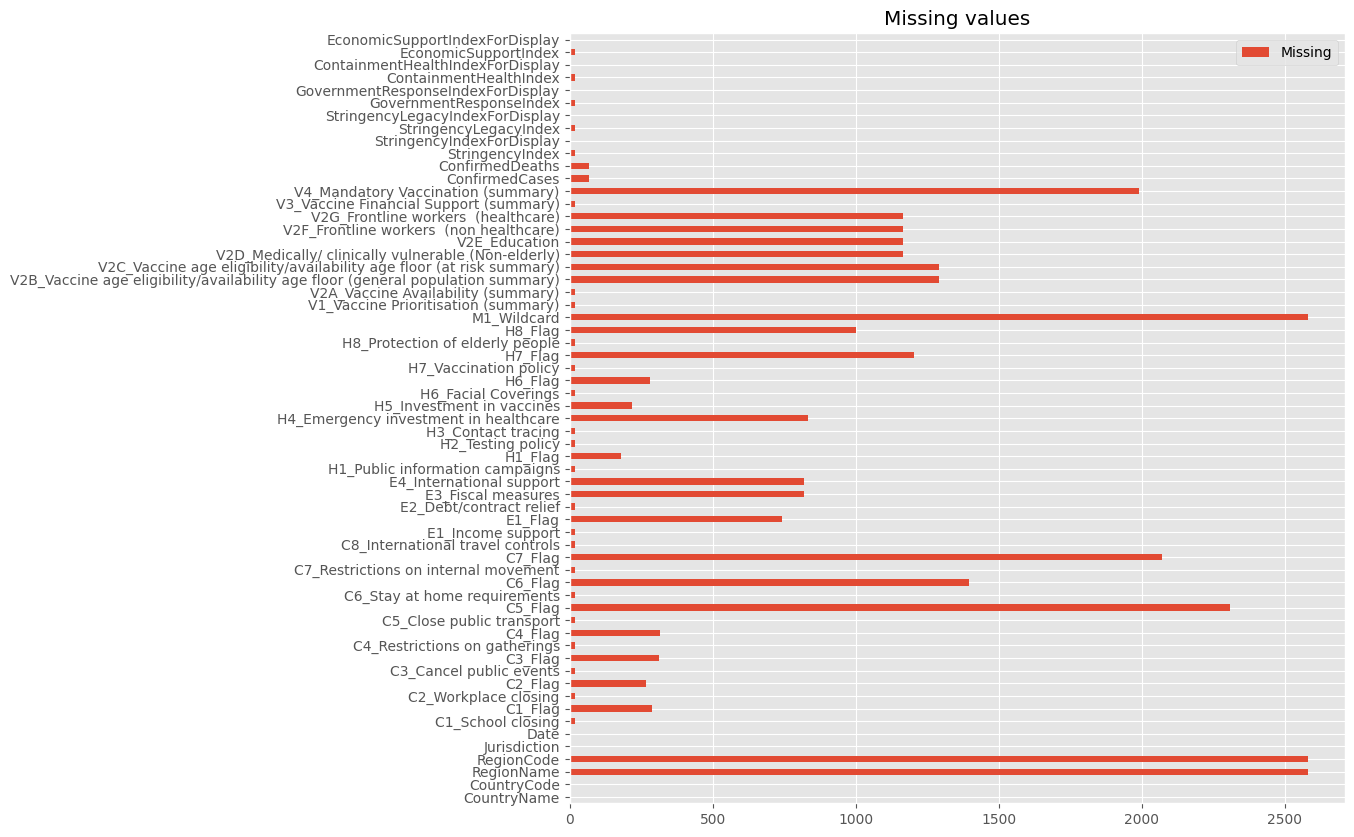

In [ ]:
figure = pd.DataFrame(data.isnull().sum(),columns = ["Missing"]).plot(kind='barh')
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.title('Missing values')

### handling missing values


In [ ]:
ms = pd.DataFrame(data.isnull().sum())
ms.columns = ["Missing"]

data = data.drop(ms.index[ms['Missing']==len(data)],axis=1)

### Fixing the dates of our series

In [ ]:
#fix date column:
data['Date'] = pd.to_datetime(data['Date'],format='%Y%m%d')
data.index = data['Date']

### Earlier we noticed patterns of missing data, let's look closer

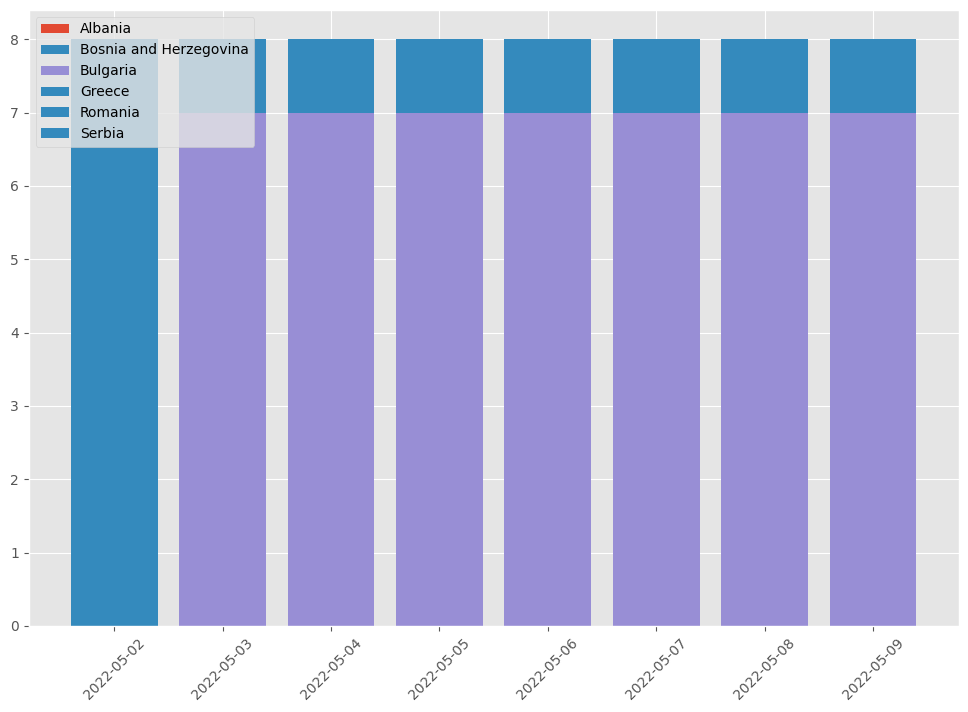

In [ ]:
#plot missing dates:
drange = pd.date_range(start = data[data['C1_School closing'].isnull()]['Date'].min(),
                       end=data[data['C1_School closing'].isnull()]['Date'].max())

#list with dates
dates = [[] for i in range(0,len(countries))]

for i in range(0,len(countries)):

        dates[i] = data[(data['C1_School closing'].isnull()) &
                                  (data['CountryName']==countries[i])]['Date']

plt.figure(figsize = (12, 8))
for i in range(0,len(dates)):
    plt.bar(dates[i],len(dates[i]),label=countries[i])
plt.legend(loc='best')
plt.xticks(drange,rotation = 45);

### We will drop the records after 20 april, because they distort the analysis

In [ ]:
data = data.drop(data[data['Date'] >= dt.datetime(2022,4,20)].index,axis=0)

### There is also a pattern in vacine policy values NAs, for example vaccine education:

In [ ]:
for c in countries:
    print(f'Missing vaccine education policy values for {c} are:\n',data[(data['V2E_Education'].isnull())
                                                & (data['CountryName']==c)]["Date"].max())

for c in countries:
    print(f'Missing vaccine education policy values values for {c} are:\n',data[(data['V2E_Education'].isnull())
                                                & (data['CountryName']==c)]["Date"].min())

Missing vaccine education policy values for Albania are:
 2021-01-10 00:00:00
Missing vaccine education policy values for Bosnia and Herzegovina are:
 2021-02-11 00:00:00
Missing vaccine education policy values for Bulgaria are:
 2020-12-26 00:00:00
Missing vaccine education policy values for Greece are:
 NaT
Missing vaccine education policy values for Romania are:
 NaT
Missing vaccine education policy values for Serbia are:
 NaT
Missing vaccine education policy values values for Albania are:
 2020-01-01 00:00:00
Missing vaccine education policy values values for Bosnia and Herzegovina are:
 2020-01-01 00:00:00
Missing vaccine education policy values values for Bulgaria are:
 2020-01-01 00:00:00
Missing vaccine education policy values values for Greece are:
 NaT
Missing vaccine education policy values values for Romania are:
 NaT
Missing vaccine education policy values values for Serbia are:
 NaT


### The pattern is most probably due to lack of vacine technologies at the times, we can fill missing vals with 0s

In [ ]:
data[[x for x in data.columns if re.search('V[0-9]',x)]] = data[[x for x in data.columns if re.search('V[0-9]',x)]].fillna(0)

### 'Flag' variables are binary indicators for geographic scope, they are included in calculating the index variables, such as Government Responce Index etc. Let's examine them.

In [ ]:
for col in data:
    if "Flag" in col:
        print(data[col].value_counts(),data[col].isnull().sum())

C1_Flag
1.0    2220
0.0      46
Name: count, dtype: int64 254
C2_Flag
1.0    2070
0.0     217
Name: count, dtype: int64 233
C3_Flag
1.0    2177
0.0      68
Name: count, dtype: int64 275
C4_Flag
1.0    2224
0.0      16
Name: count, dtype: int64 280
C5_Flag
1.0    168
0.0    102
Name: count, dtype: int64 2250
C6_Flag
1.0    934
0.0    239
Name: count, dtype: int64 1347
C7_Flag
1.0    385
0.0    114
Name: count, dtype: int64 2021
E1_Flag
0.0    978
1.0    847
Name: count, dtype: int64 695
H1_Flag
1.0    2359
Name: count, dtype: int64 161
H6_Flag
1.0    2273
Name: count, dtype: int64 247
H7_Flag
1.0    1335
Name: count, dtype: int64 1185
H8_Flag
1.0    1111
0.0     442
Name: count, dtype: int64 967


### There are many missing values as well as class imbalance so we remove them

In [ ]:
data = data.drop([x for x in data.columns if "Flag" in x],axis=1)

### To further imporve the data preprocessing let's count all columns with a singular unique value and then check if the different countries in the panel data have a similar pattern of columns with a singular value

In [ ]:
vals = pd.Series() #singalar value columns per country
lists = [] #a list of all vals

for i in range(0,len(countries)):
    vals = data[data['CountryName']==countries[i]].apply(lambda col: len(col.dropna().unique())) == 1
    lists.append(vals[vals==True].index)

ident = [] #a list for all variables in lists

for i in lists:
    for j in i:
        ident.append(j)

print('Indentically singular columns are:')

for i in set(ident):

    if ident.count(i) == len(lists):
        print(i)

Indentically singular columns are:


### There is a pattern of singular value columns between the countries and we have also discovered that some countries have had mandatory vaccination policies, while others haven't had. This a feature that we will analyze, but first let's remove singular value columns.

In [ ]:
ident = set([x for x in ident if ident.count(x) == len(lists)]) #obtain the uniformly singular columns

# Check if 'CountryName' is in the set before attempting to remove it
if 'CountryName' in ident:
    ident.remove('CountryName') #we want to keep country name

data = data.drop(ident,axis=1)
data.shape #check the number of remaining columns

(2520, 46)

### Now we want to fill all remaining missing values in the data:

<Axes: >

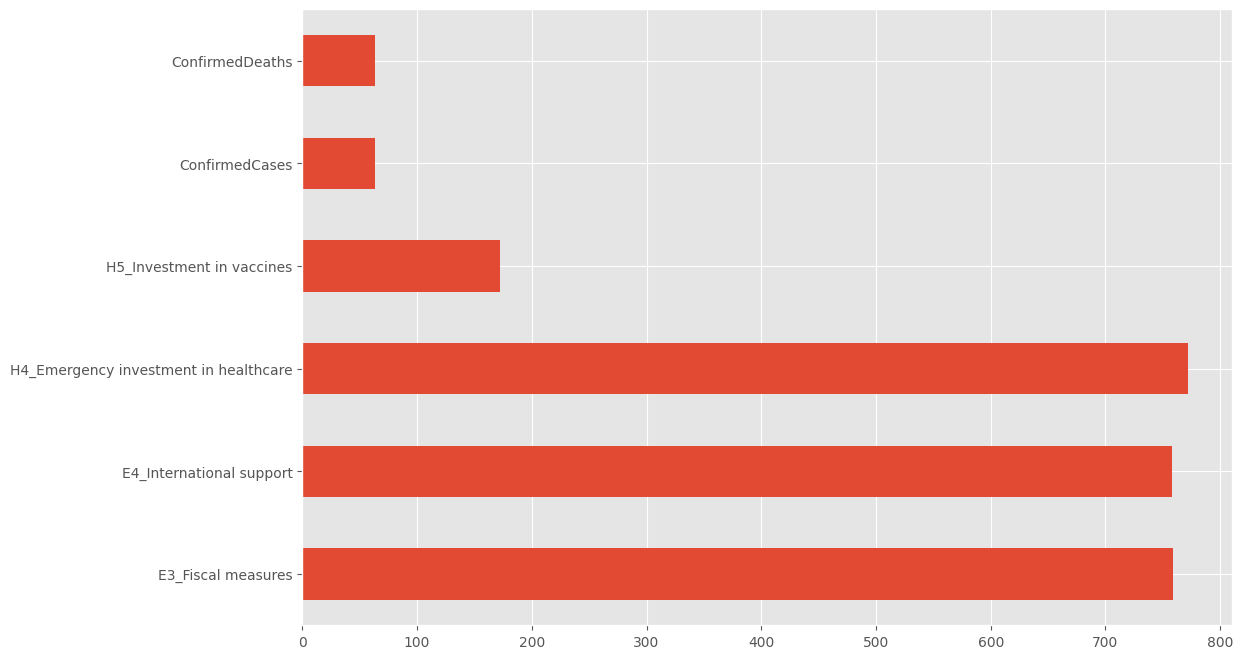

In [ ]:
plt.figure(figsize = (12, 8))
data[data.columns[data.isnull().any()]].isnull().sum().plot(kind='barh') #select only columns with missing data and plot them

### There are only 5 variables left with missing data - one is "Mandatory vaccination", categorical variable and the others are numerical variables.
### We can assume that the nulls for "Mandatory vaccination" are due to vacines not being yet availiable so we can confidently fill them with 0s

In [ ]:
data[data.select_dtypes(include=np.number).columns] = data[data.select_dtypes(
    include=np.number).columns].fillna(0) #select numerical columns and fill them with 0s

data.isnull().sum() #there are no more missing values

CountryName                                                                        0
CountryCode                                                                        0
Jurisdiction                                                                       0
Date                                                                               0
C1_School closing                                                                  0
C2_Workplace closing                                                               0
C3_Cancel public events                                                            0
C4_Restrictions on gatherings                                                      0
C5_Close public transport                                                          0
C6_Stay at home requirements                                                       0
C7_Restrictions on internal movement                                               0
C8_International travel controls                                 

### Drop days where there were no registered cases

In [ ]:
#fist day of a registered case:
for c in countries:
   print(f'The first Covid-19 case in {c} was on:',data[(data['CountryName']==c) & (data['ConfirmedCases'] != 0)].index.min())

#let's drop the dates before 2020-03-09:
data = data[data.index > '2020-03-09']

The first Covid-19 case in Albania was on: 2020-03-09 00:00:00
The first Covid-19 case in Bosnia and Herzegovina was on: 2020-03-05 00:00:00
The first Covid-19 case in Bulgaria was on: 2020-03-08 00:00:00
The first Covid-19 case in Greece was on: NaT
The first Covid-19 case in Romania was on: NaT
The first Covid-19 case in Serbia was on: NaT


### We removed the unnecasary data and villed in the missing variables, the data is clean and tidy - we can now start the data analysis. We'll begin by calculating the number of daily cases for each contry - the "daily_cases" variable:

In [ ]:
#daily cases feature:
daily_cases = pd.Series()

for c in countries:
    temp = data[data['CountryName']==c]['ConfirmedCases'] - data[
            data['CountryName']==c]['ConfirmedCases'].shift(1)
    daily_cases = pd.concat([daily_cases,temp],axis = 0)
    temp = pd.Series()

data['daily_cases'] = daily_cases
data['daily_cases'] = data['daily_cases'].fillna(0)

### Let's now visualize the daily new cases for each country as well as the weekly moving average:

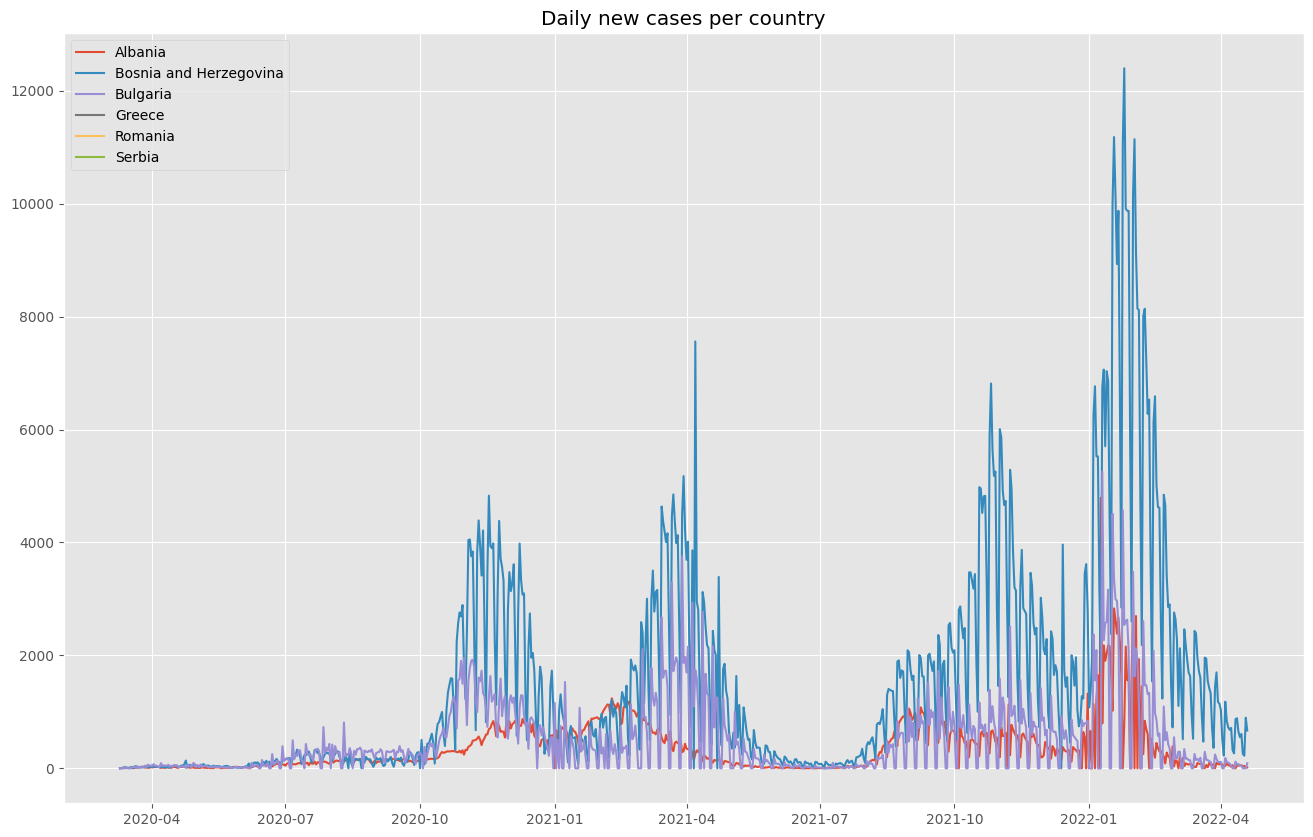

In [ ]:
#daily cases jointplot
plt.figure(figsize = (16, 10))
for i in range(0,len(countries)):
    plt.plot(data[data['CountryName']==countries[i]]['daily_cases'].index,
             data[data['CountryName']==countries[i]]['daily_cases'],label=countries[i])
plt.title("Daily new cases per country")
plt.legend()

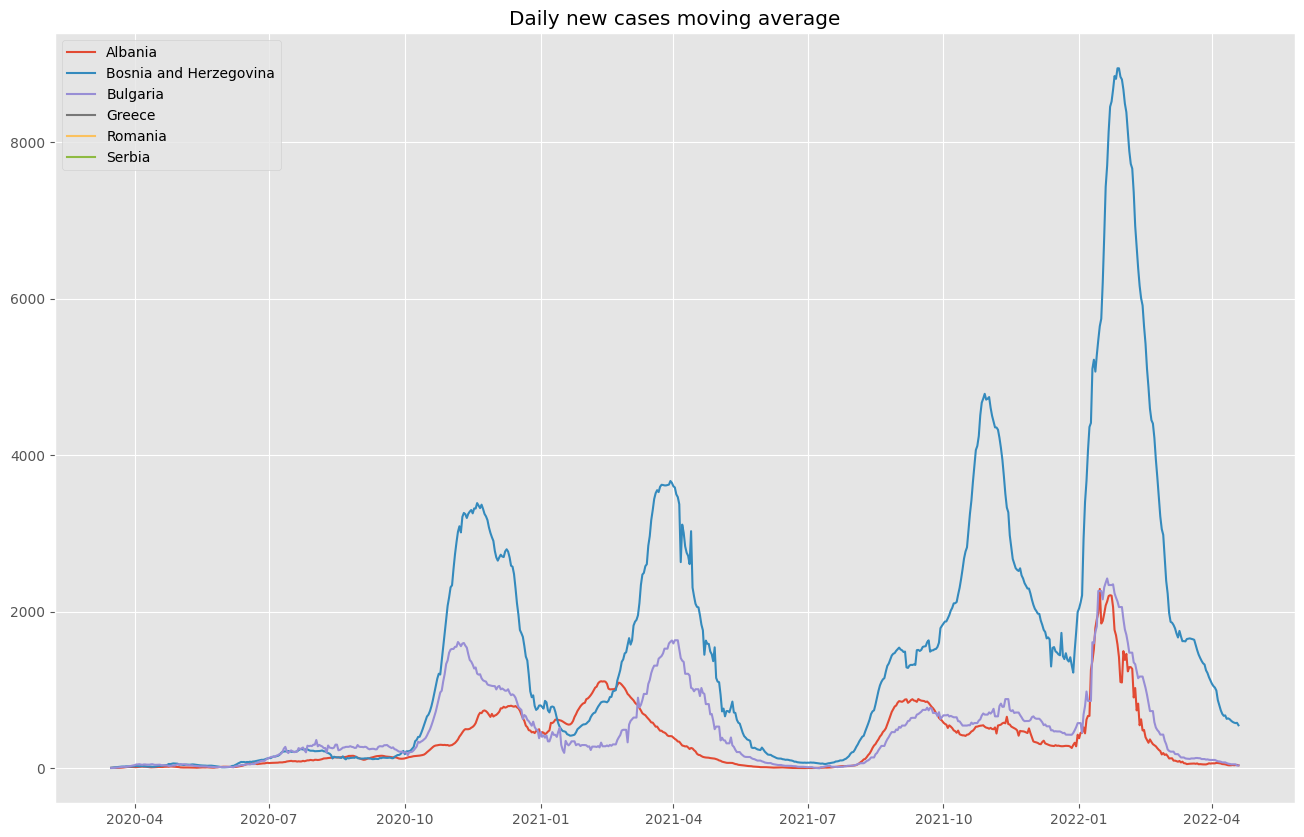

In [ ]:
#7-day moving average
plt.figure(figsize = (16, 10))
for i in range(0,len(countries)):
    plt.plot(data[data['CountryName']==countries[i]]['daily_cases'].index,
             data[data['CountryName']==countries[i]]['daily_cases'].rolling(7).mean(),label=countries[i])
plt.title("Daily new cases moving average")
plt.legend()

### Earlier we noticed the Mandatory vaccination variable and the fact that some countries have had mandatory vaccination while others - not. Let's have a closer by discovering the earliest and latest date when the policy was implemented.

In [ ]:
print('First day: ',data[(data['V4_Mandatory Vaccination (summary)']==1) & (data['CountryName']=='Greece')]['Date'].min())
print('Last day: ',data[(data['V4_Mandatory Vaccination (summary)']==1) & (data['CountryName']=='Greece')]['Date'].max())

First day:  NaT
Last day:  NaT


### Now the same for Albania:

In [ ]:
print('First day: ',data[(data['V4_Mandatory Vaccination (summary)']==1) & (data['CountryName']=='Albania')]['Date'].min())
print('Last day: ',data[(data['V4_Mandatory Vaccination (summary)']==1) & (data['CountryName']=='Albania')]['Date'].max())

First day:  2021-09-30 00:00:00
Last day:  2022-04-19 00:00:00


### Now let's move on with more feature engineering. We'll create weekly and biweekly changes in Covid cases, based on rolling windows

count    2274.000000
mean             inf
std              NaN
min        -1.000000
25%        -0.199867
50%        -0.016620
75%         0.253703
max              inf
dtype: float64


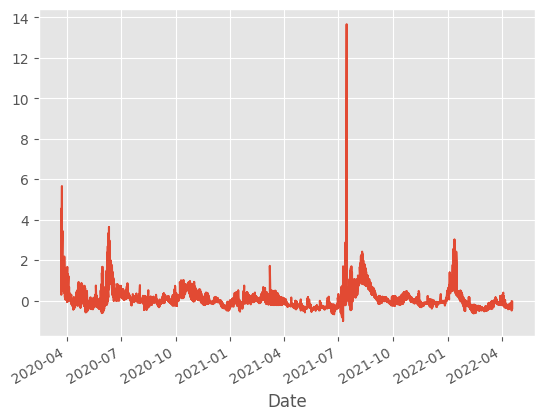

In [ ]:
#lets creat a week over week variable with a new function:
def rolling(window,var):
    """a percent change function for n-day window periods"""
    w_change = pd.Series()
    temp = pd.Series(np.zeros(shape=int(len(data)/len(countries))))

    for c in countries:

        temp = (data[data['CountryName']==c][var].rolling(
            window).sum() - data[data['CountryName']==c][var].shift(window).rolling(
                window).sum()) / data[data['CountryName']==c][var].shift(window).rolling(window).sum()

        w_change = pd.concat([w_change,temp],axis=0)
        temp = pd.Series(np.zeros(shape=int(len(data)/len(countries))))

    return(w_change)

#create the weekly change variable:
weekly = rolling(7,'daily_cases')
weekly.index = data.index

#visualize new variable
plt.figure()
weekly.plot()

#get some info about the variable
print(weekly.describe())

#clean inf values
weekly[weekly== np.inf] = 0

#concat the variable to the dataset
data['weekly_change'] = weekly

### Here we are going to use the function to create a biweekly change variable:

In [ ]:
#add biweekly change
bi_weekly = rolling(14,'daily_cases')

bi_weekly.index = data.index
data['biweekly_change'] = bi_weekly

bi_weekly.describe()

count    2232.000000
mean        0.257555
std         0.887003
min        -0.732588
25%        -0.324596
50%        -0.007062
75%         0.509867
max         6.191083
dtype: float64

### Now we are ready to do some data analysis using more advanced charts and statistical methods, but let's first take a look at the values of policy index variables:

In [ ]:
data[[x for x in data.columns if re.search('Index',x)]]

,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
Date,,,,,,,,,,
2020-03-10,41.67,41.67,46.43,46.43,36.46,36.46,41.67,41.67,0.0,0.0
2020-03-11,51.85,51.85,60.71,60.71,42.19,42.19,48.21,48.21,0.0,0.0
2020-03-12,51.85,51.85,60.71,60.71,42.19,42.19,48.21,48.21,0.0,0.0
2020-03-13,78.70,78.70,84.52,84.52,57.29,57.29,65.48,65.48,0.0,0.0
2020-03-14,78.70,78.70,84.52,84.52,57.29,57.29,65.48,65.48,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2022-04-15,36.11,36.11,48.81,48.81,38.02,38.02,43.45,43.45,0.0,0.0
2022-04-16,36.11,36.11,48.81,48.81,38.02,38.02,43.45,43.45,0.0,0.0
2022-04-17,36.11,36.11,48.81,48.81,38.02,38.02,43.45,43.45,0.0,0.0


### Now let's create some plots of the variable "GovernmentResponseIndex" and weekly change in cases as a function of time

<Figure size 640x480 with 0 Axes>

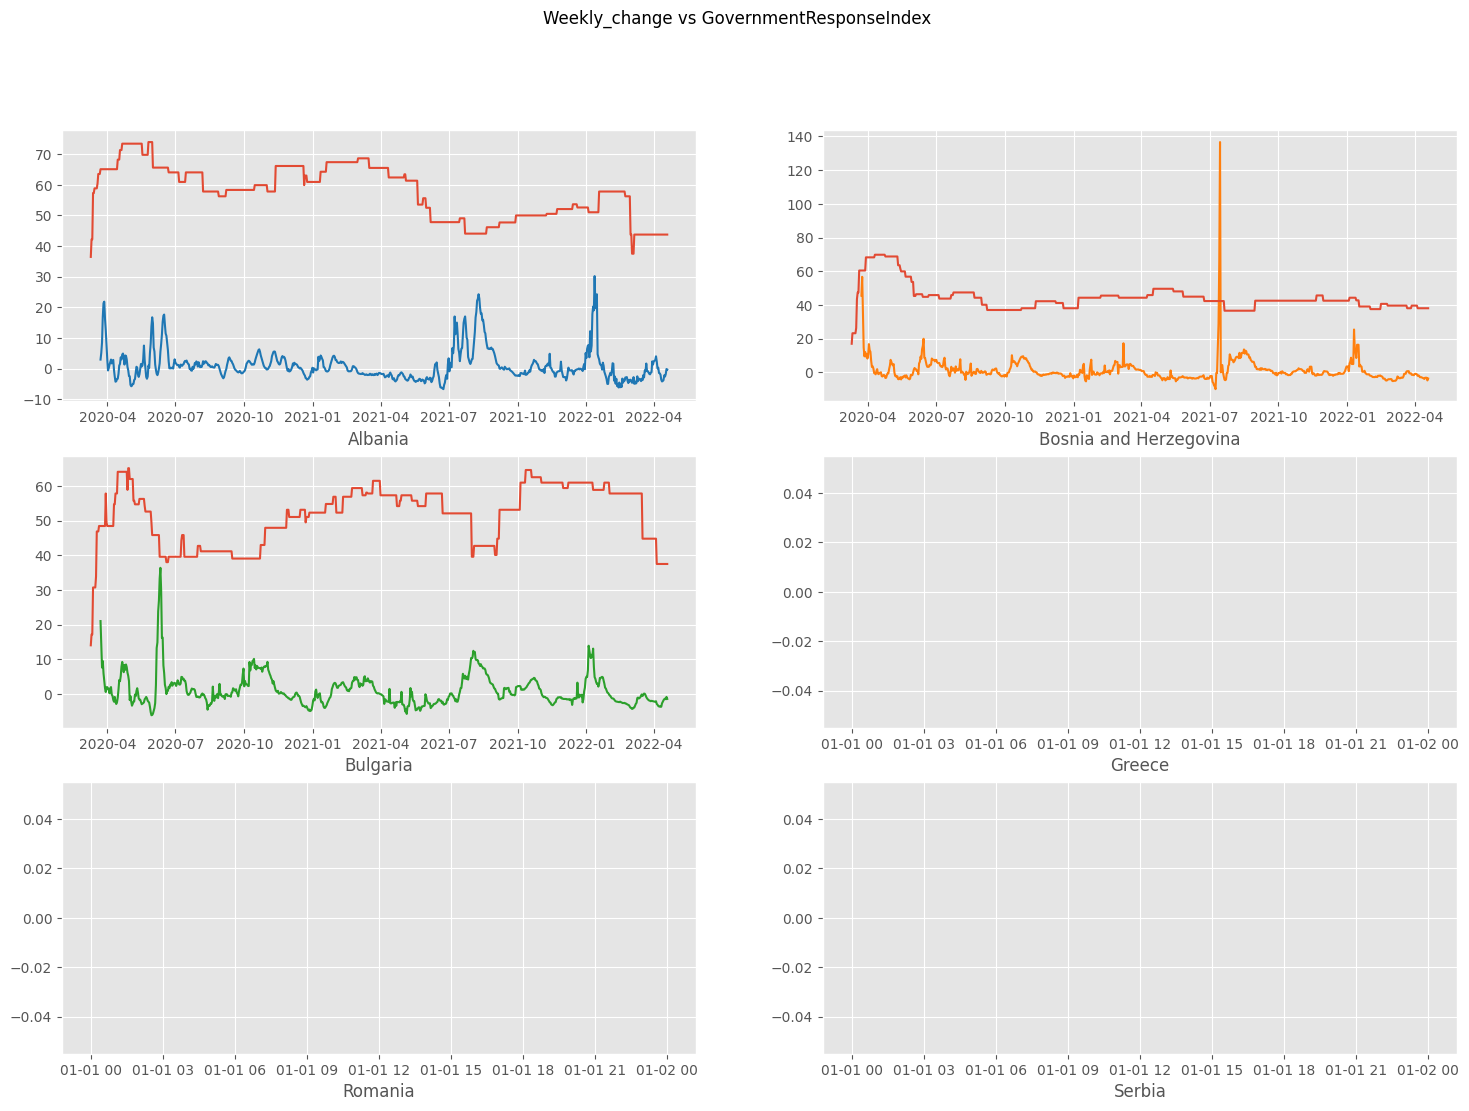

In [ ]:
total = len(countries)
col_len = math.ceil(len(countries)/2)
row_len = total // col_len
row_len += total % col_len
position = range(1,total+1)

#weekly change
plt.figure(figsize = (18, 12))
plt.figure()
fig1 = plt.figure(1)
for k in range(total):

  ax1 = fig1.add_subplot(col_len,row_len,position[k])
  fig1.suptitle('Weekly_change vs GovernmentResponseIndex')
  ax1.plot(data[data['CountryName']==countries[k]]['weekly_change']*10,
           color = list(mcolors.TABLEAU_COLORS.keys())[k])
  ax1.plot(data[data['CountryName']==countries[k]]['GovernmentResponseIndex'])
  ax1.set_xlabel(countries[k])

### The indeces are variables in interval scale, ranging from 0 to 100. They are comprised from a linear combination of the specific policy variables,such as "Workplace_closing by using the following formula:

![](https://camo.githubusercontent.com/54eb9a88a8d99e9dd7cfd592b4b5cb3d065fd3f42a101caabbf57a6ae8c90f74/68747470733a2f2f6c617465782e636f6465636f67732e636f6d2f7376672e696d6167653f283529495f2537426a2532437425374425334431303025354366726163253742765f2537426a253243742537442d302e35253238465f2537426a2537442d665f2537426a253243742537442532392537442537424e5f2537426a253744253744)

### Where:
* (Nj) is the maximum value of the indicator
* (Fj) is whether that indicator has a flag (Fj=1 if the indicator has a flag variable, or 0 if the indicator does not have a flag variable)
* (vj,t) is the recorded policy value on the ordinal scale
* (fj,t) is the recorded binary flag for that indicator

The GovernmentResponseIndex variable represents goverment's overall activity in introducing antipandemic policies, and StringencyIndex represent the strictness of measures for example - the higher the variable, the stricter is the locdown policy.

### Every index variable is made from the following specific policy variables:

![indecestable.png](attachment:6be856bc-55f6-40f6-b6ca-4a3af440c423.png)



### Ok. Let's now do the same plot as above, but with the biweekly change

<Figure size 640x480 with 0 Axes>

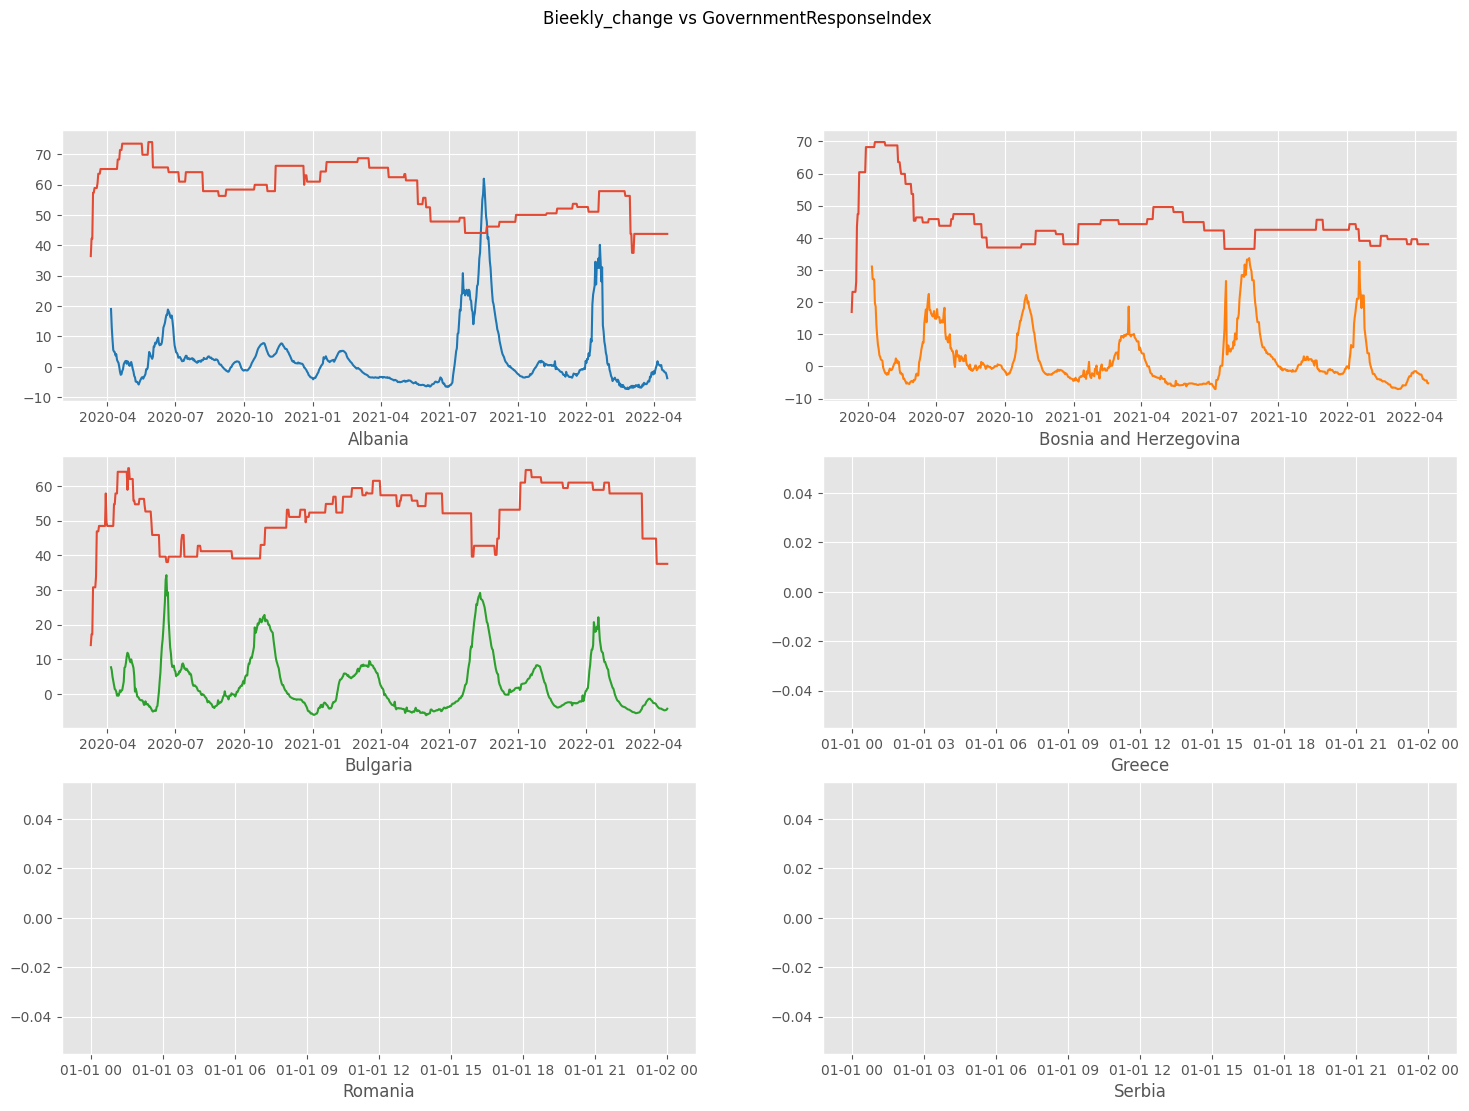

In [ ]:
#biweekly change
plt.figure(figsize = (18, 12))
plt.figure()
fig1 = plt.figure(1)
for k in range(total):

  ax1 = fig1.add_subplot(col_len,row_len,position[k])
  fig1.suptitle('Bieekly_change vs GovernmentResponseIndex')
  ax1.plot(data[data['CountryName']==countries[k]]['biweekly_change']*10,
           color = list(mcolors.TABLEAU_COLORS.keys())[k])
  ax1.plot(data[data['CountryName']==countries[k]]['GovernmentResponseIndex'])
  ax1.set_xlabel(countries[k])

### Let's plot the goverment response and strictness indeces for each country.

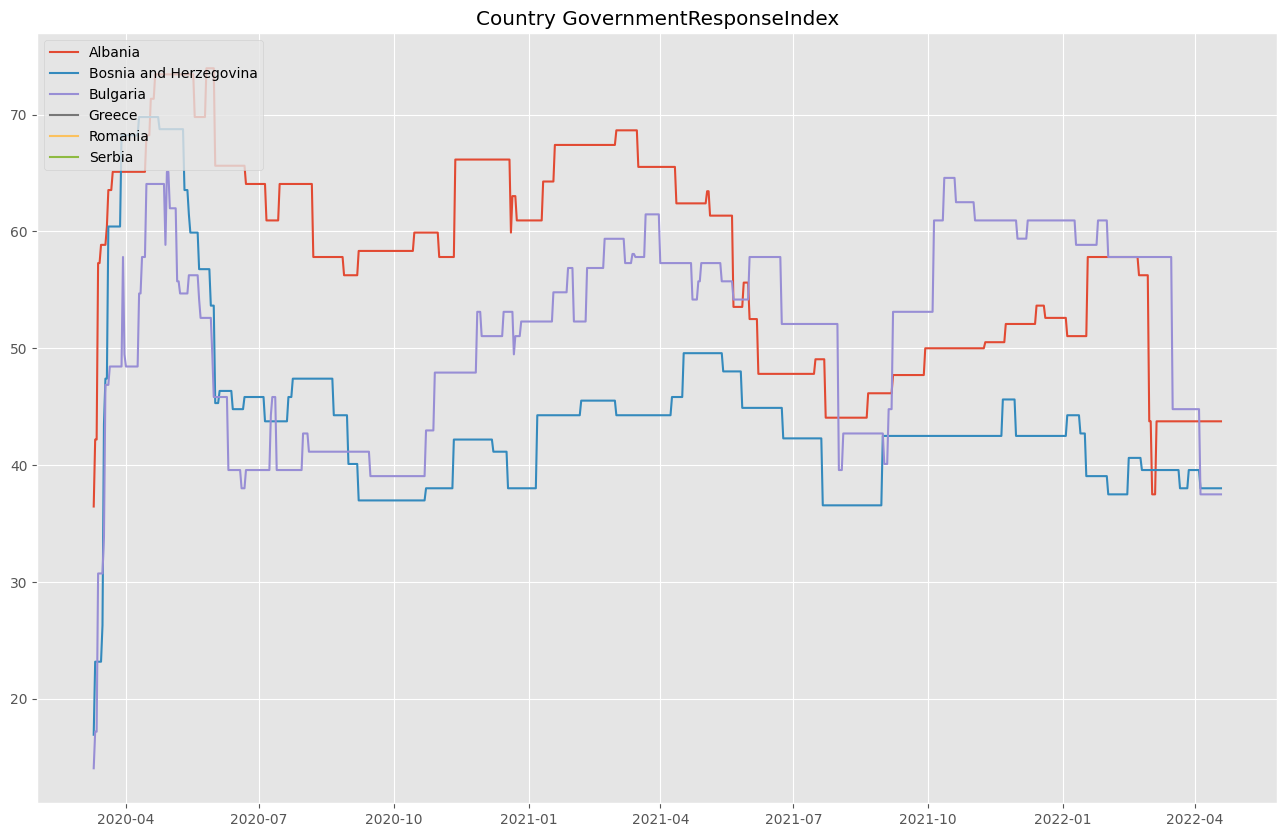

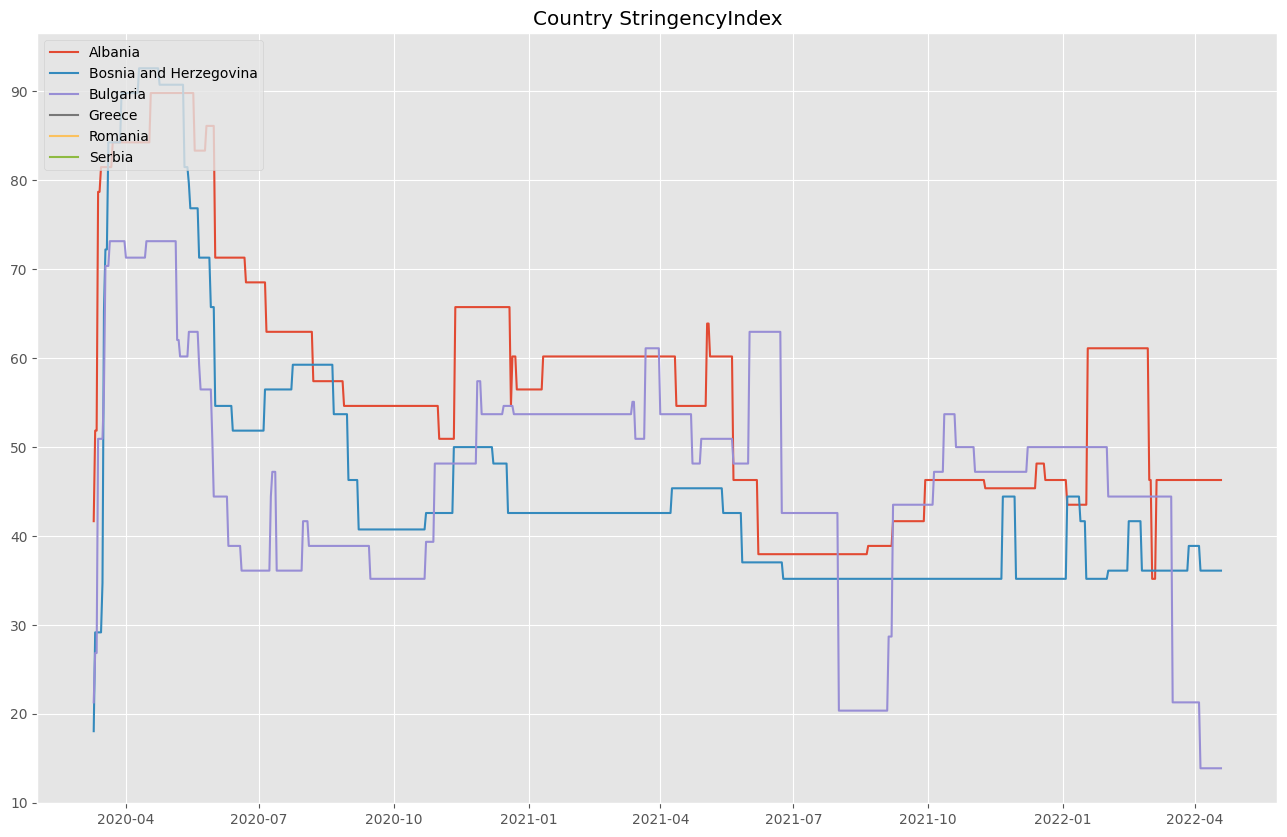

In [ ]:
#goverment response index and str index
plt.figure(figsize = (16, 10))
for c in countries:

    plt.plot(data[data['CountryName']==c].index, data[data['CountryName']==c]['GovernmentResponseIndex'],label=c)
    plt.title('Country GovernmentResponseIndex')
    plt.legend(loc='upper left')

plt.figure(figsize = (16, 10))
for c in countries:

    plt.plot(data[data['CountryName']==c].index, data[data['CountryName']==c]['StringencyIndex'],label=c)
    plt.title('Country StringencyIndex')
    plt.legend(loc='upper left')

### After we've explained the indeces, it should be also usefull to look deeper into the specific policy variables and obtain some information about their values. Let's start with the variables accounting for containment and closure policies:

In [ ]:
data[[x for x in data.columns if re.search('C[0-9]',x)]]

,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls
Date,,,,,,,,
2020-03-10,3.0,0.0,2.0,2.0,0.0,0.0,0.0,1.0
2020-03-11,3.0,2.0,2.0,2.0,0.0,0.0,0.0,2.0
2020-03-12,3.0,2.0,2.0,2.0,0.0,0.0,0.0,2.0
2020-03-13,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2020-03-14,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...
2022-04-15,1.0,1.0,1.0,2.0,0.0,1.0,0.0,1.0
2022-04-16,1.0,1.0,1.0,2.0,0.0,1.0,0.0,1.0
2022-04-17,1.0,1.0,1.0,2.0,0.0,1.0,0.0,1.0


### Let's see a summarize view of the variable's vallues:

In [ ]:
[data[x].value_counts() for x in data.columns if re.search('C[0-9]',x)]

[C1_School closing
 1.0    1030
 2.0     904
 3.0     326
 0.0      53
 Name: count, dtype: int64,
 C2_Workplace closing
 1.0    1223
 2.0     992
 3.0      72
 0.0      26
 Name: count, dtype: int64,
 C3_Cancel public events
 2.0    1194
 1.0    1050
 0.0      69
 Name: count, dtype: int64,
 C4_Restrictions on gatherings
 3.0    1328
 4.0     603
 2.0     220
 1.0      88
 0.0      74
 Name: count, dtype: int64,
 C5_Close public transport
 0.0    2043
 2.0     170
 1.0     100
 Name: count, dtype: int64,
 C6_Stay at home requirements
 0.0    1140
 2.0     773
 1.0     365
 3.0      35
 Name: count, dtype: int64,
 C7_Restrictions on internal movement
 0.0    1814
 2.0     344
 1.0     155
 Name: count, dtype: int64,
 C8_International travel controls
 1.0    982
 3.0    811
 2.0    256
 0.0    143
 4.0    121
 Name: count, dtype: int64]

### We can see that we are dealing with multiple instances of categorical data, in an ordinal scale. Nevertheless, what interests us the most are the variables for health system policies - H and vaccination policies - V, since the containment and closure policies and economic policies are used to get the StringencyIndex and EconomicSupportIndex and are absorbed in the values of the aforementioned indeces.


In [ ]:
data[[x for x in data.columns if re.search('H[0-9]',x)]]

,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H7_Vaccination policy,H8_Protection of elderly people
Date,,,,,,,,
2020-03-10,2.0,1.0,1.0,0.0,0.0,1.0,0.0,3.0
2020-03-11,2.0,1.0,1.0,0.0,0.0,1.0,0.0,3.0
2020-03-12,2.0,1.0,1.0,0.0,0.0,1.0,0.0,3.0
2020-03-13,2.0,1.0,1.0,0.0,0.0,1.0,0.0,3.0
2020-03-14,2.0,1.0,1.0,0.0,0.0,1.0,0.0,3.0
...,...,...,...,...,...,...,...,...
2022-04-15,2.0,2.0,0.0,0.0,0.0,2.0,5.0,2.0
2022-04-16,2.0,2.0,0.0,0.0,0.0,2.0,5.0,2.0
2022-04-17,2.0,2.0,0.0,0.0,0.0,2.0,5.0,2.0


### Again, we have categorical variables in an ordinal scale. And finaly, let's see the vaccination policies:

In [ ]:
data[[x for x in data.columns if re.search('V[0-9]',x)]]

,V1_Vaccine Prioritisation (summary),V2A_Vaccine Availability (summary),V2B_Vaccine age eligibility/availability age floor (general population summary),V2C_Vaccine age eligibility/availability age floor (at risk summary),V2D_Medically/ clinically vulnerable (Non-elderly),V2E_Education,V2F_Frontline workers (non healthcare),V2G_Frontline workers (healthcare),V3_Vaccine Financial Support (summary),V4_Mandatory Vaccination (summary)
Date,,,,,,,,,,
2020-03-10,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-11,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-12,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-13,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-14,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2022-04-15,2.0,3.0,5-15 yrs,5-15 yrs,2.0,2.0,2.0,2.0,5.0,0.0
2022-04-16,2.0,3.0,5-15 yrs,5-15 yrs,2.0,2.0,2.0,2.0,5.0,0.0
2022-04-17,2.0,3.0,5-15 yrs,5-15 yrs,2.0,2.0,2.0,2.0,5.0,0.0


### It would be interesting and usefull if we could draw some inferences between the governmet's policies and the rate of change of Covid cases. In order do so, let's first check for correlations between the weekly change and the variables of interest.

### We will exclude the GovernmentResponseIndex variable, since it contains too many other features and therefore we'll have multicolinearity

Text(0.5, 1.0, 'Correlations between govermnet indeces and weekly change of covid cases')

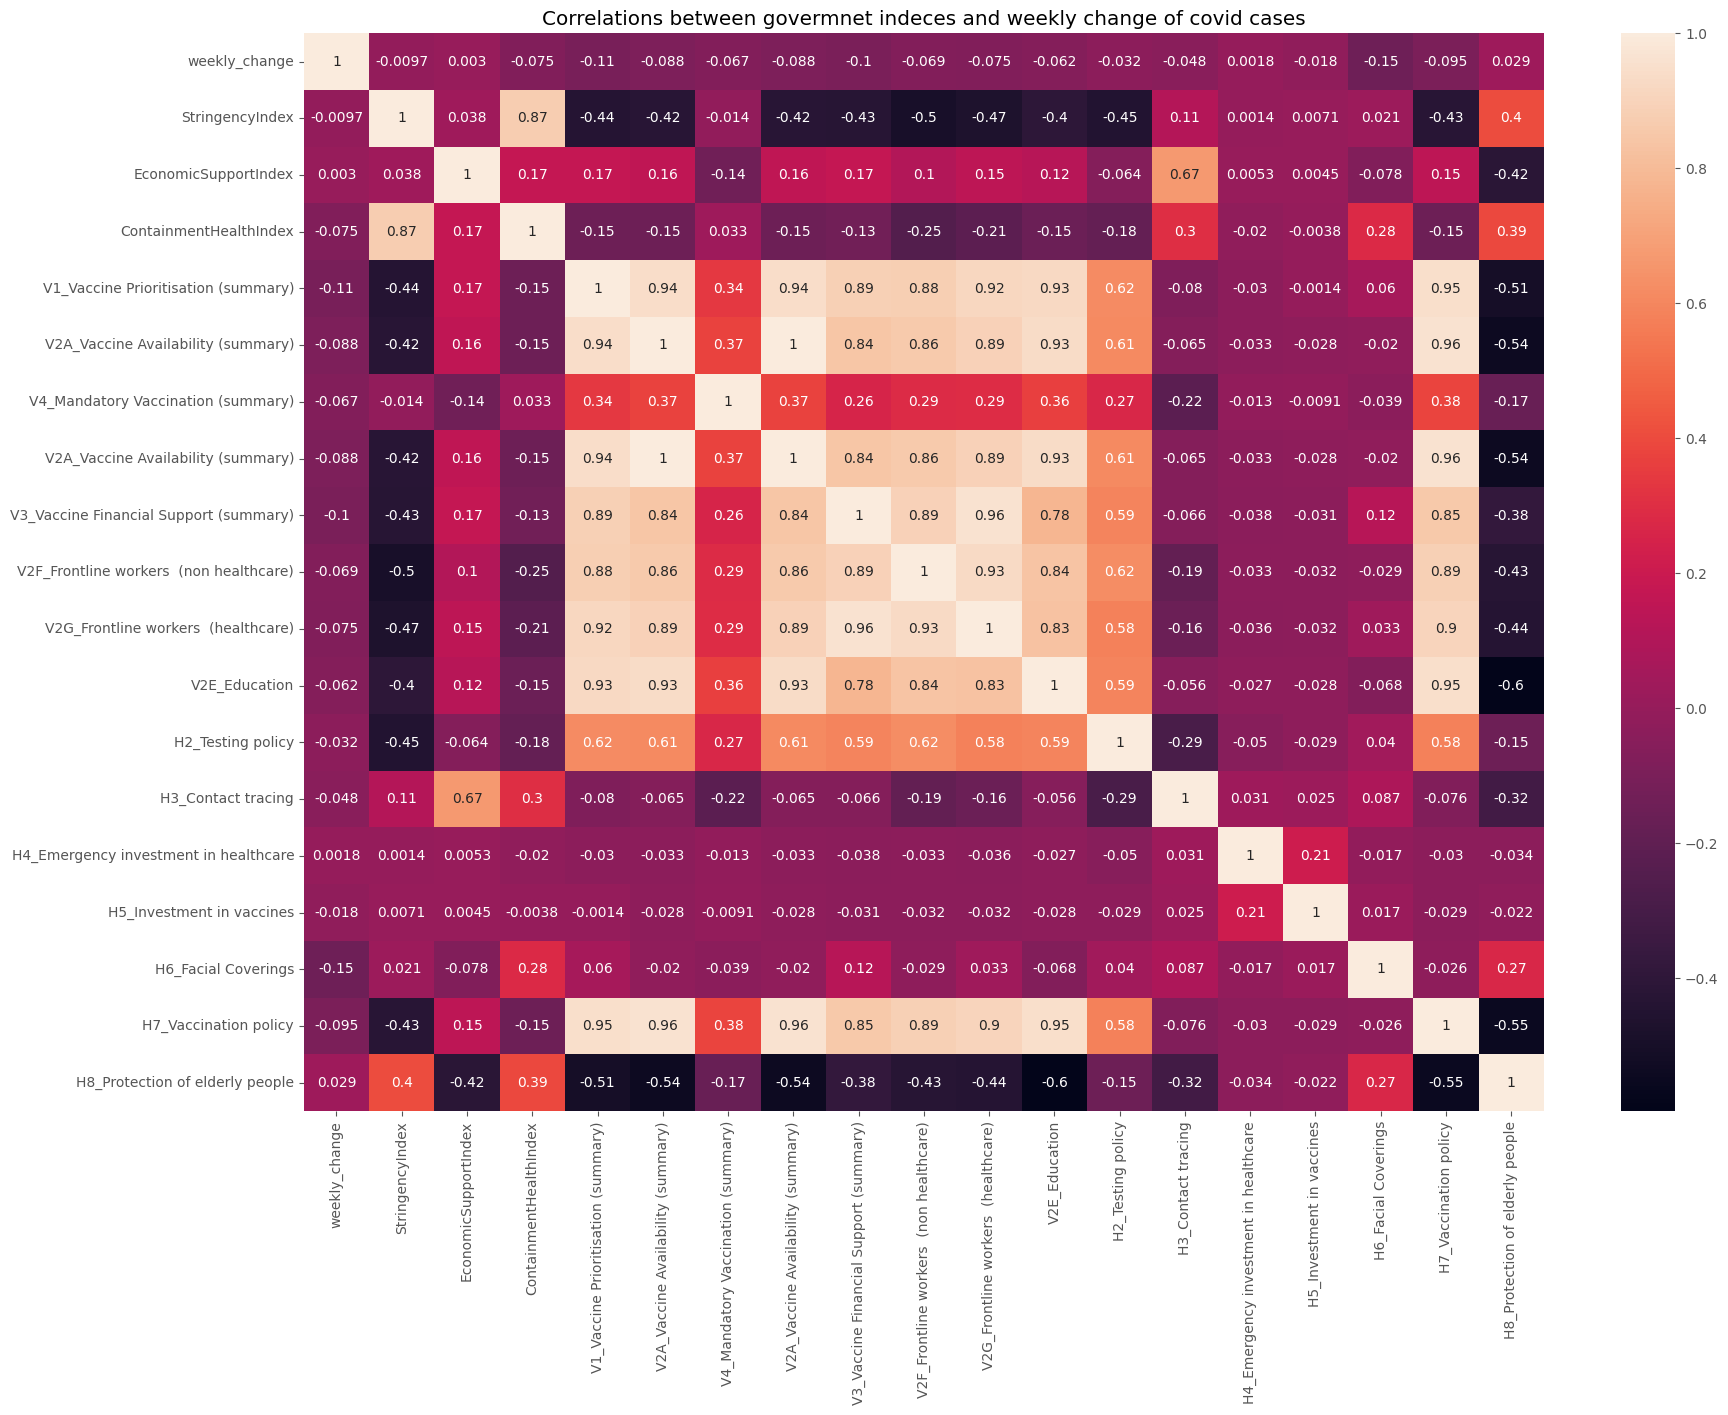

In [ ]:
#correlation plot indeces and vaccination policies
plt.figure(figsize = (20, 14))
sns.heatmap(data[['weekly_change','StringencyIndex',
                                 'EconomicSupportIndex',
                                 'ContainmentHealthIndex','V1_Vaccine Prioritisation (summary)','V2A_Vaccine Availability (summary)',
                                 'V4_Mandatory Vaccination (summary)','V2A_Vaccine Availability (summary)',
                                 'V3_Vaccine Financial Support (summary)','V2F_Frontline workers  (non healthcare)','V2G_Frontline workers  (healthcare)',
                                    'V2E_Education' ,'H2_Testing policy', 'H3_Contact tracing','H4_Emergency investment in healthcare',
                                     'H5_Investment in vaccines','H6_Facial Coverings','H7_Vaccination policy','H8_Protection of elderly people']].corr(),annot = True)

plt.title('Correlations between govermnet indeces and weekly change of covid cases')

### And now a second correlation plot using biweekly change

Text(0.5, 1.0, 'Correlations between govermnet indeces and weekly change of covid cases')

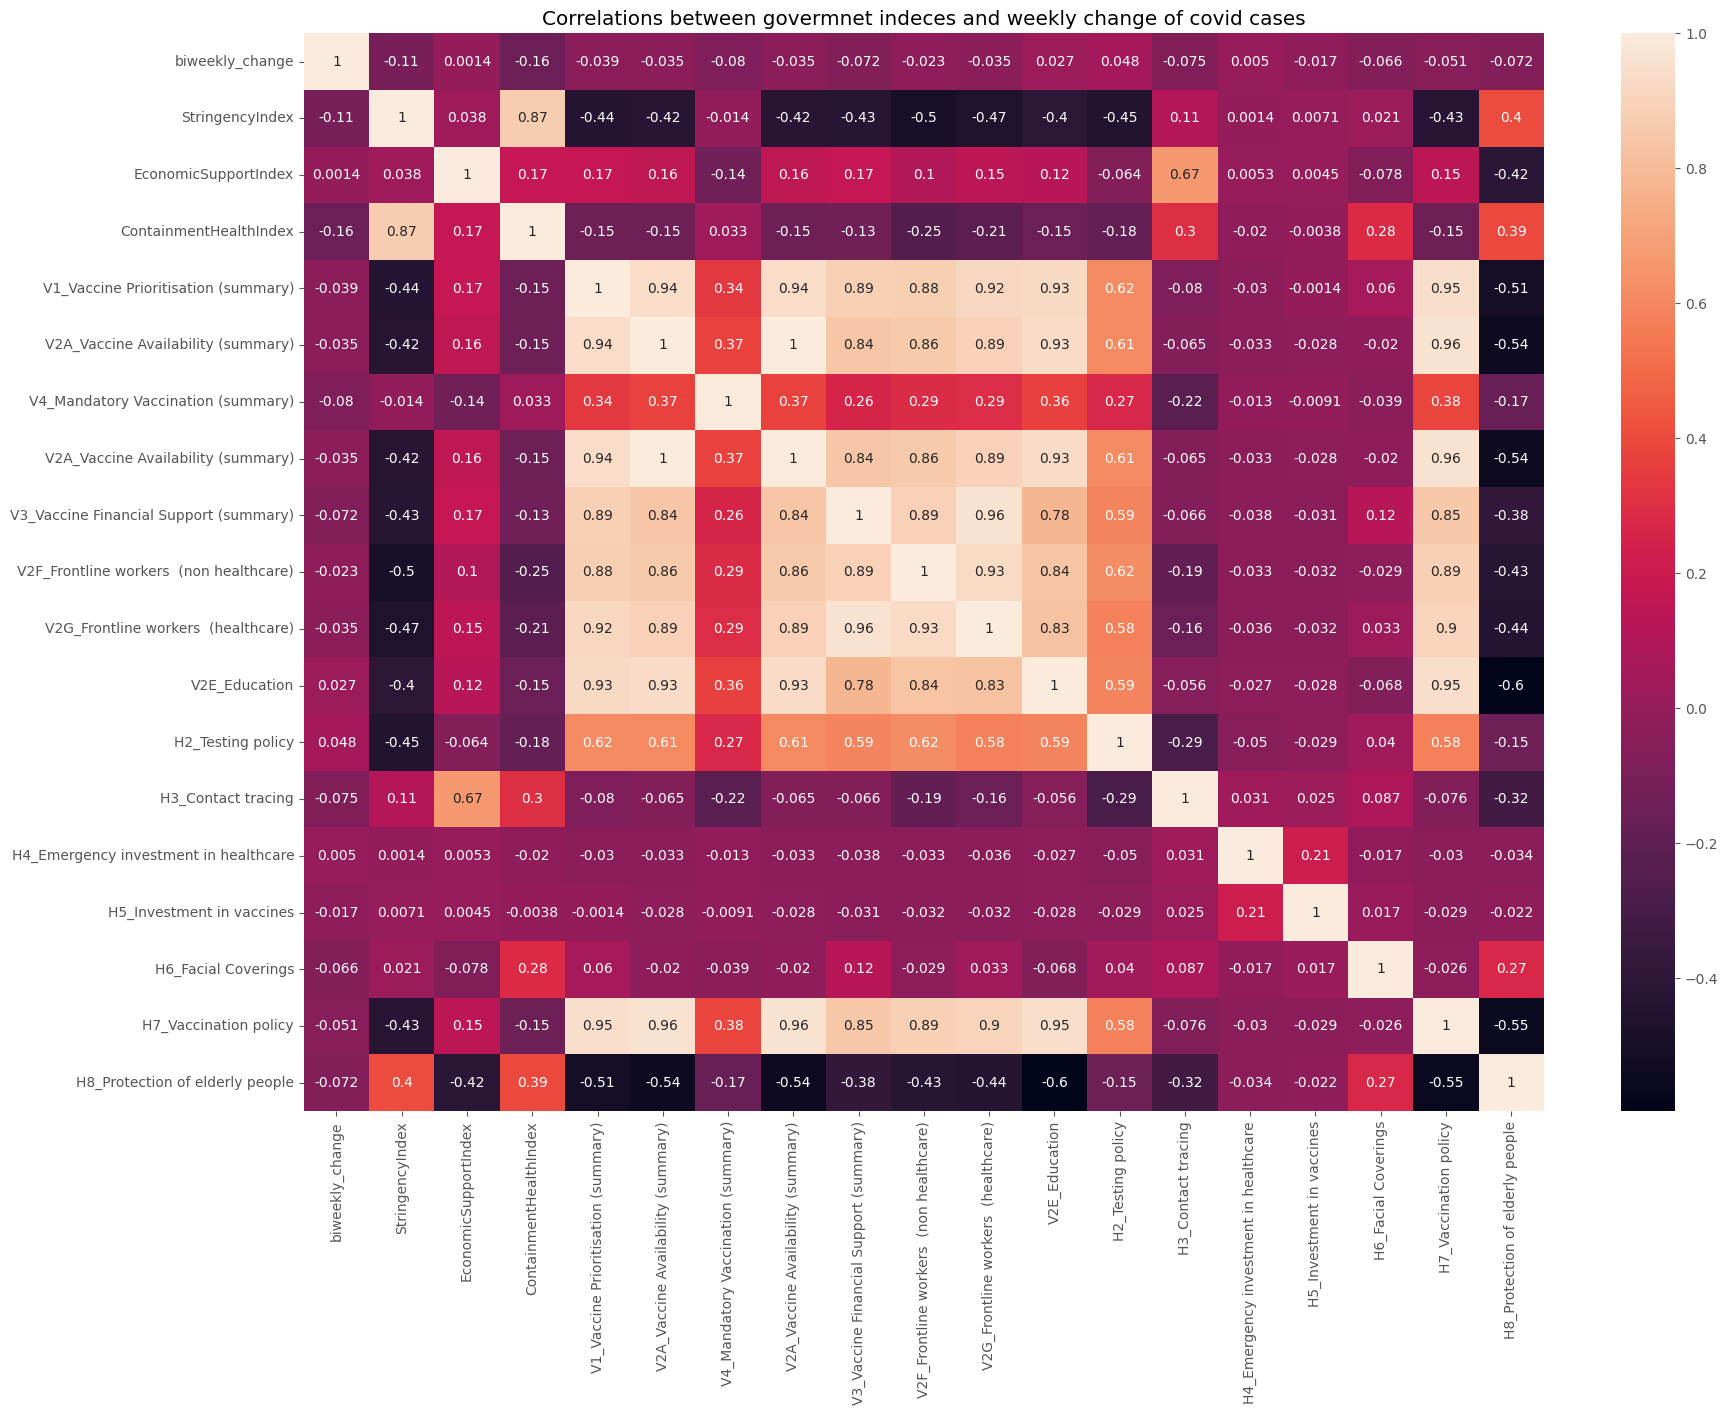

In [ ]:
#correlation plot indeces and vaccination policies
plt.figure(figsize = (20, 14))
sns.heatmap(data[['biweekly_change','StringencyIndex',
                                 'EconomicSupportIndex',
                                 'ContainmentHealthIndex','V1_Vaccine Prioritisation (summary)','V2A_Vaccine Availability (summary)',
                                 'V4_Mandatory Vaccination (summary)','V2A_Vaccine Availability (summary)',
                                 'V3_Vaccine Financial Support (summary)','V2F_Frontline workers  (non healthcare)','V2G_Frontline workers  (healthcare)',
                                    'V2E_Education' ,'H2_Testing policy', 'H3_Contact tracing','H4_Emergency investment in healthcare',
                                     'H5_Investment in vaccines','H6_Facial Coverings','H7_Vaccination policy','H8_Protection of elderly people']].corr(),annot = True)

plt.title('Correlations between govermnet indeces and weekly change of covid cases')

### We have several problems with this correlation matrix. First, we don't see any strong linear relationship between the target variable - biweekly_change and the features. Also, we have multicolinearity between many of the features, this means that we'll have to do some more feature engineering before we continue modelling.

### Furthermore, because we analyze time series data, we are dealing with the effect of autocorrelation between the values of the target variable. As a rule of thumb, before modelling we need to remove the trend effect from data. We can do that, by simply shuffling the dataset random so that each observation's place is picked on a random basis by the computer. This will remove the autocorelation in the target variable.

<Axes: >

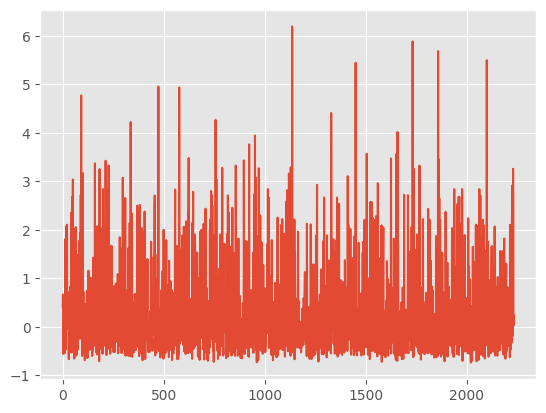

In [ ]:
##shuffle dataset to remove the trend effect
l = list(range(0,len(data)))
random.seed(1) #add random state for reproducibility
shuffledList = random.sample(l, k=len(l))

sdata = data.iloc[shuffledList]
sdata = sdata.dropna(subset=['biweekly_change'])

###info about the target
sdata['biweekly_change'].describe()

#plot the shuffled target
plt.figure()
pd.Series(sdata['biweekly_change'].values).plot()

### Now we have a target variable that's independent of time. To fix the multicolinearity problem and still preserve as much information as possible we can use the technique known as Principle Component Analysis. For this purpose we will isolate only the highly correlated features and use the technique on them.

percentage of explained variance for the first, second and last princip. components respectively:  [0.88649934 0.06460637 0.02362478]


<Axes: >

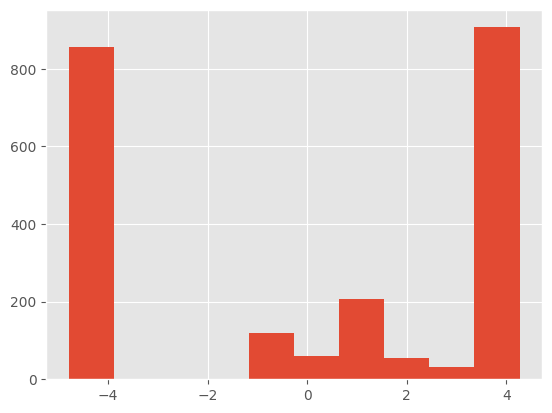

In [ ]:
#select the required features. the features are of the same scale, so we don't need to transform them
features = sdata[['V1_Vaccine Prioritisation (summary)','V2A_Vaccine Availability (summary)',
                               'V3_Vaccine Financial Support (summary)' , 'V2E_Education',
                                 'V2F_Frontline workers  (non healthcare)',
                                 'V2G_Frontline workers  (healthcare)',
                                    'V2E_Education' ,'H2_Testing policy','H7_Vaccination policy']]

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(features)

features = pca.transform(features)

#get the & of variance explained by the new features
print('percentage of explained variance for the first, second and last princip. components respectively: ',pca.explained_variance_ratio_)

#flip the signs to the negative plane
principalComponents = -principalComponents

pc1 = principalComponents[:,0]
sdata['vaccine_effect'] = pc1
sdata['vaccine_effect'].hist()

### Now, after we created our new varriable, let's convert it back to the ordinal scale

<Axes: >

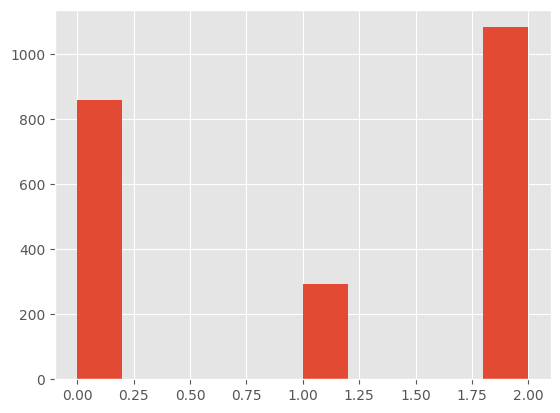

In [ ]:
#binning - let's bin the new variable, in order to return it to it's previous ordinal scale:
min_value = sdata['vaccine_effect'].min()
max_value = sdata['vaccine_effect'].max()

bins = np.linspace(min_value,max_value,4)

sdata['vac_bins'] = pd.cut(sdata['vaccine_effect'], bins=bins, labels=[0,1,2], include_lowest=True)
sdata['vac_bins'] = sdata['vac_bins'].astype('int')

plt.figure()
sdata['vac_bins'].hist()

### Neat, we have an ordinal scale variable that's more suitable for the analysis technique we will use next - ANOVA. Before we continue, however, we need to assign some meaning to it. We could imagine that it's a catergory of how availible the vaccines are to the society, with the 0 value being - zero to low proliferation of the vaccine, 1 - medium prolifereation and 2, strong vaccine proliferation.

### Continuing forwards, let's alson bin the StringencyIndex and EconomicSupportIndex features

In [ ]:
#now we should also rework the indeces - let's make them equally spaced
bins = np.arange(0, 120, 20)

sdata['strindex_bin'] = pd.cut(sdata['StringencyIndex'], bins=bins, labels=[0,1,2,3,4], include_lowest=True)
sdata['strindex_bin'] = sdata['strindex_bin'].astype('int')

bins = np.arange(0, 120, 20)

sdata['ecoindex_bin'] = pd.cut(sdata['EconomicSupportIndex'], bins=bins, labels=[0,1,2,3,4], include_lowest=True)
sdata['ecoindex_bin'] = sdata['ecoindex_bin'].astype('int')

### Lets visualize our newly created features and their relationship with the response variable using a scattermatrix

array([[<Axes: xlabel='biweekly_change', ylabel='biweekly_change'>,
        <Axes: xlabel='strindex_bin', ylabel='biweekly_change'>,
        <Axes: xlabel='ecoindex_bin', ylabel='biweekly_change'>,
        <Axes: xlabel='ContainmentHealthIndex', ylabel='biweekly_change'>,
        <Axes: xlabel='vac_bins', ylabel='biweekly_change'>],
       [<Axes: xlabel='biweekly_change', ylabel='strindex_bin'>,
        <Axes: xlabel='strindex_bin', ylabel='strindex_bin'>,
        <Axes: xlabel='ecoindex_bin', ylabel='strindex_bin'>,
        <Axes: xlabel='ContainmentHealthIndex', ylabel='strindex_bin'>,
        <Axes: xlabel='vac_bins', ylabel='strindex_bin'>],
       [<Axes: xlabel='biweekly_change', ylabel='ecoindex_bin'>,
        <Axes: xlabel='strindex_bin', ylabel='ecoindex_bin'>,
        <Axes: xlabel='ecoindex_bin', ylabel='ecoindex_bin'>,
        <Axes: xlabel='ContainmentHealthIndex', ylabel='ecoindex_bin'>,
        <Axes: xlabel='vac_bins', ylabel='ecoindex_bin'>],
       [<Axes: xlabel='bi

<Figure size 640x480 with 0 Axes>

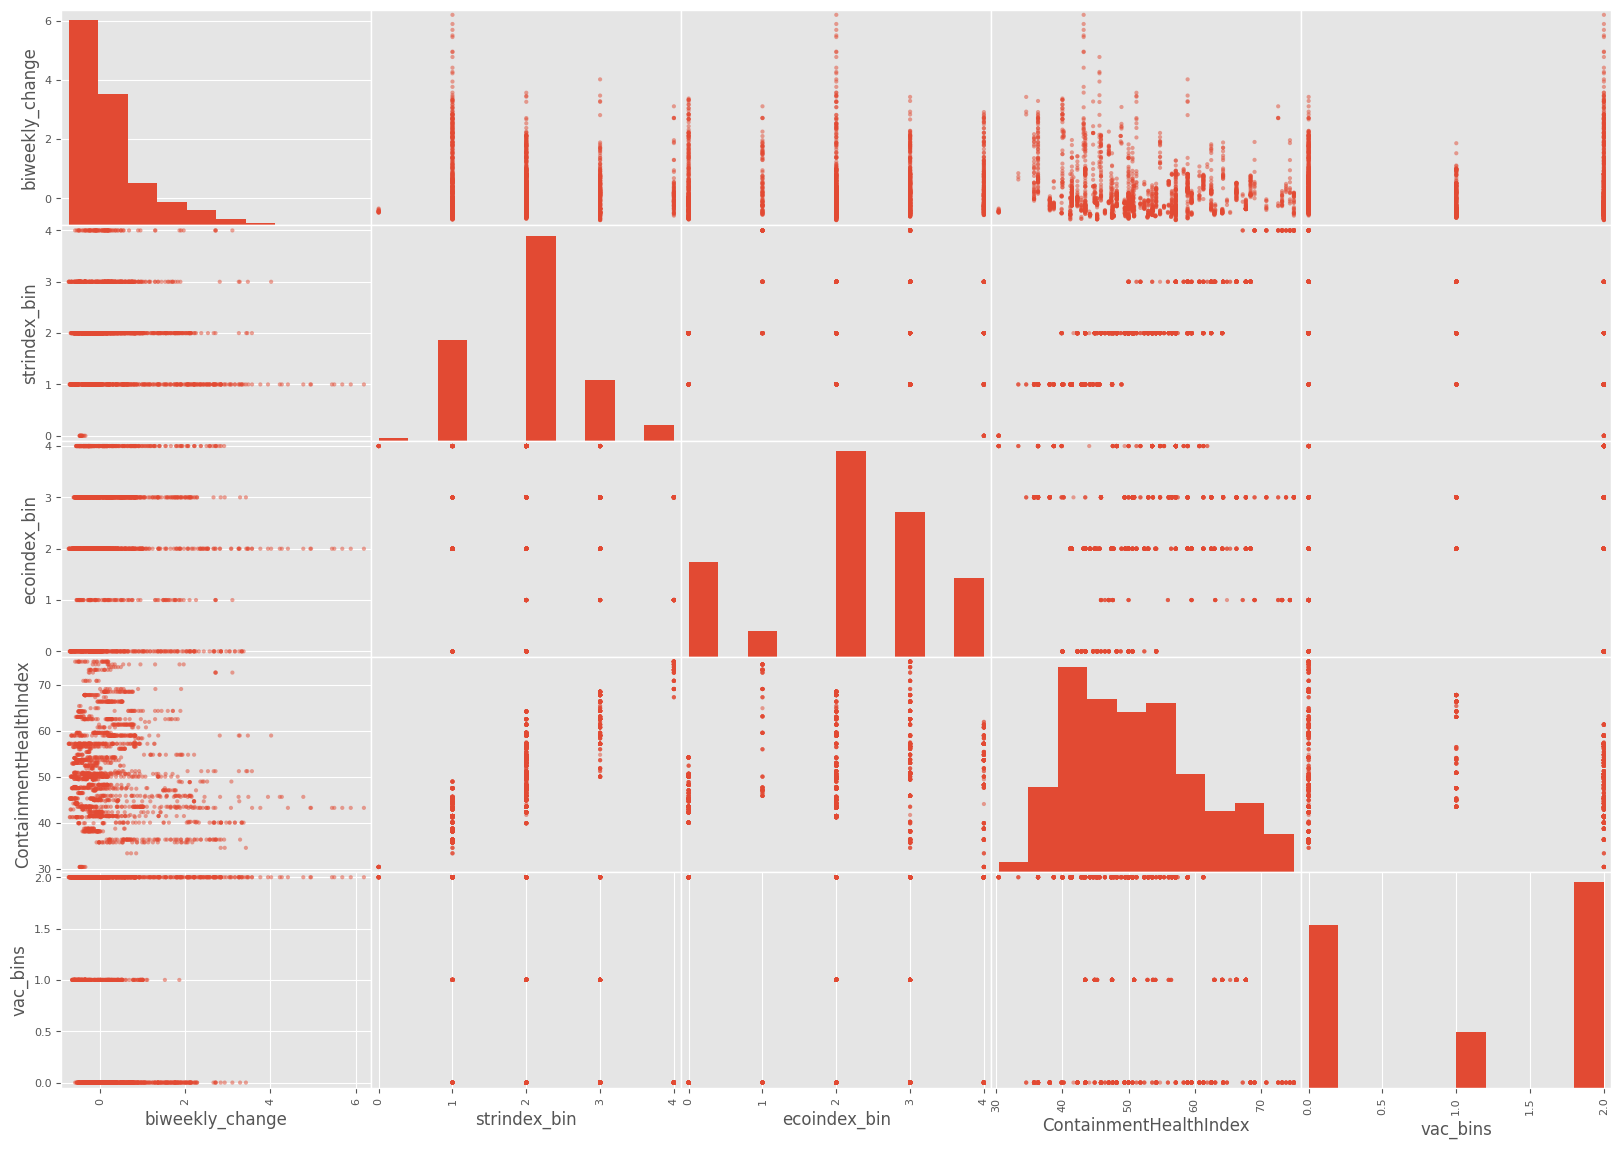

In [ ]:
plt.figure()
pd.plotting.scatter_matrix(sdata[['biweekly_change','strindex_bin','ecoindex_bin',
                                 'ContainmentHealthIndex','vac_bins']],figsize = (20, 14))

### The pariplot also allows us to detect the strong linear relation ship of ContainmentHealthIndex with the other features. We will therefore discard it from the analysis to avoid multicolinearity issues. Let's generate a new correlation matrix with the remaining variables, which are already in an ordinal scale.

<Axes: >

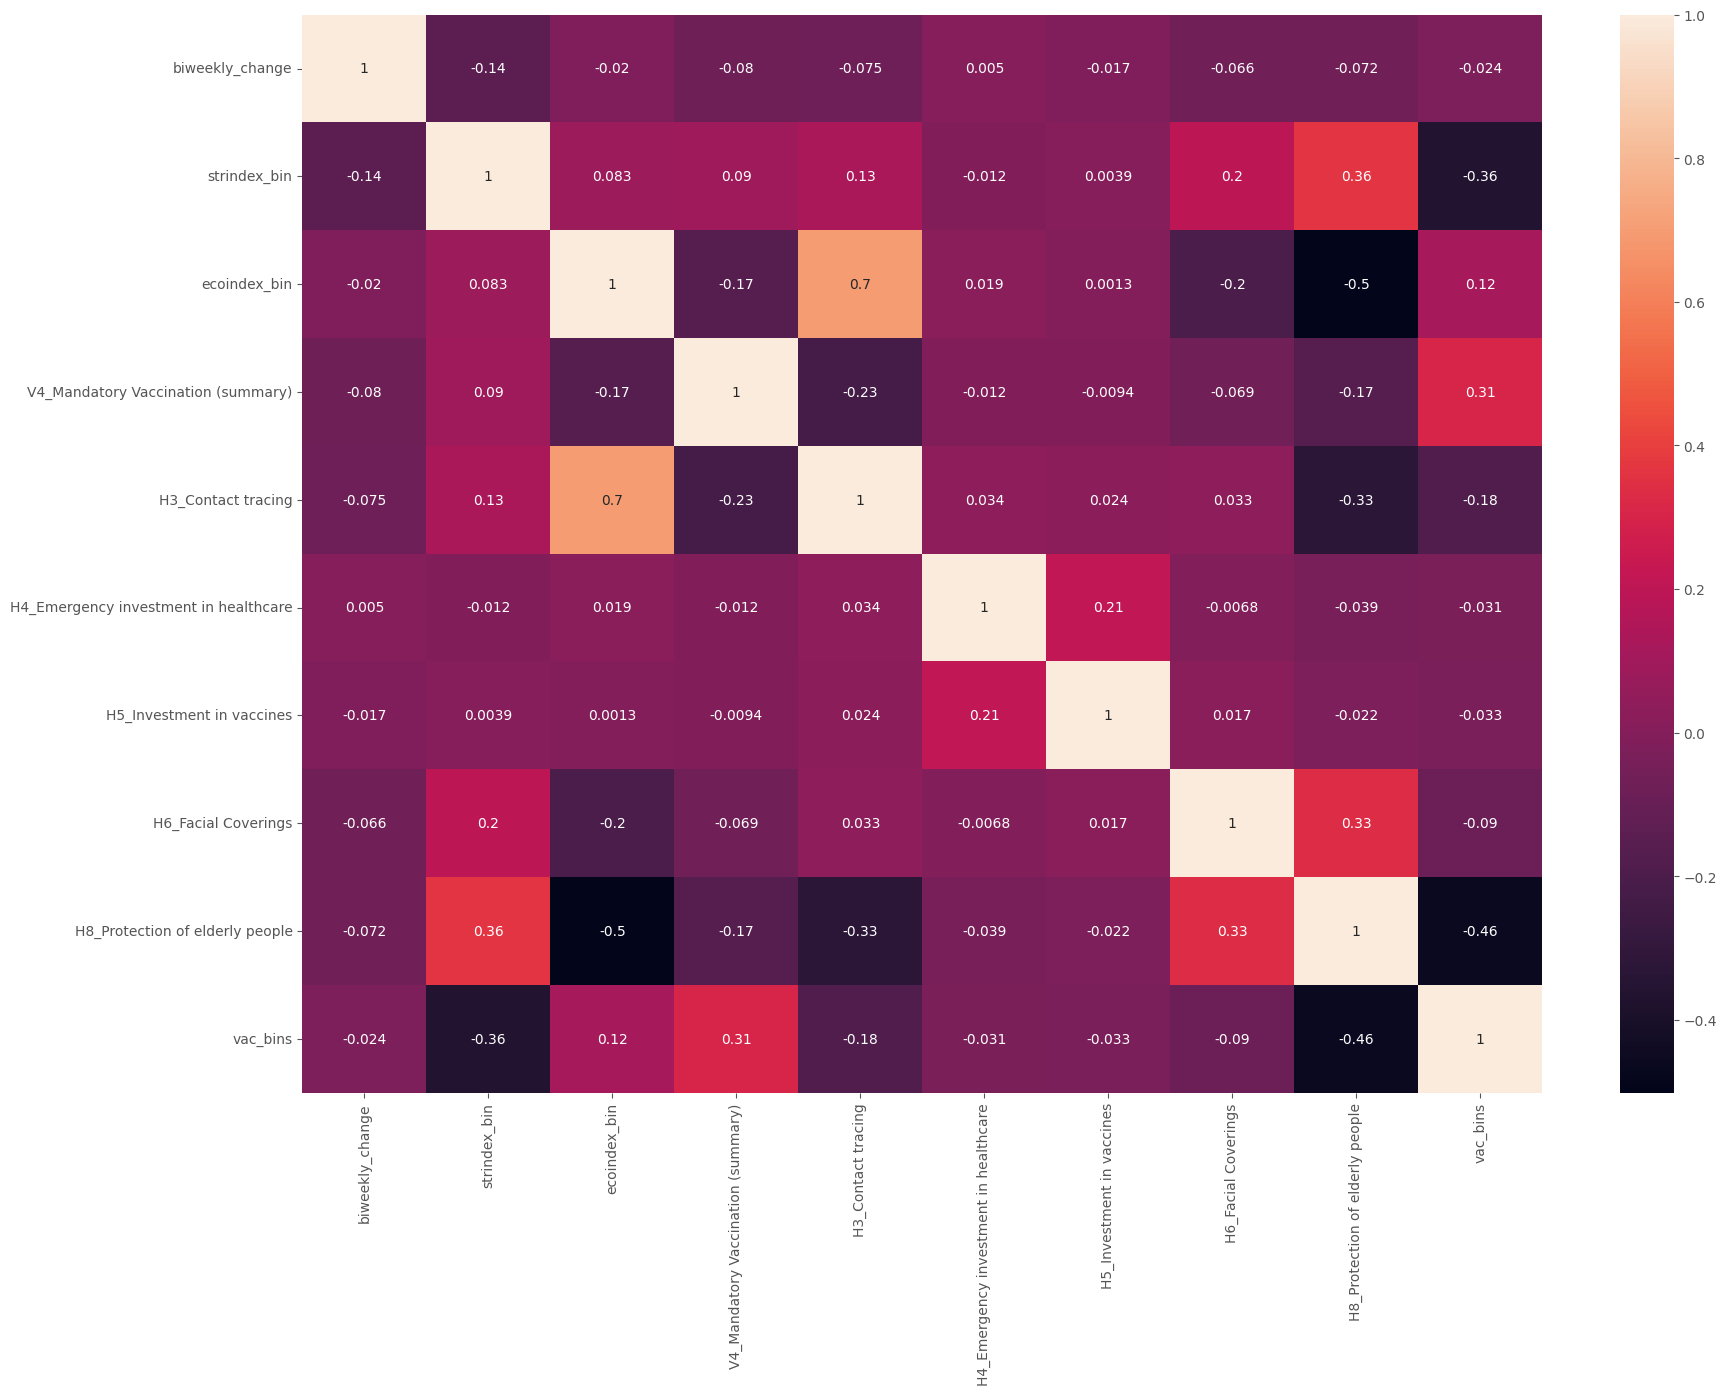

In [ ]:
plt.figure(figsize = (20, 14))
sns.heatmap(sdata[['biweekly_change','strindex_bin',
                                 'ecoindex_bin',
                                 'V4_Mandatory Vaccination (summary)',
                                    'H3_Contact tracing','H4_Emergency investment in healthcare',
                                     'H5_Investment in vaccines','H6_Facial Coverings',
                                     'H8_Protection of elderly people',
                                     'vac_bins']].corr(),annot = True)

### As a rule of thumb, when modeling we mustn't use features with high to medium mutual correaltion. This means that we will also discard the variable Contact_tracing, thus leaving us with 8 remaining features.

### Next, we transform the names of the variables to ease our modelling puproses and make them more meaningfull for interpretation

In [ ]:
sdata.rename(columns = {'H4_Emergency investment in healthcare':'investments_in_healthcare',
                       'V4_Mandatory Vaccination (summary)':'mandatory_vaccination',
                       'H6_Facial Coverings':'facial_coverings',
                       'H8_Protection of elderly people':'elders_protection_policy',
                       'H5_Investment in vaccines':'investments_in_vaccines',
                        'vac_bins':'proliferation_of_vaccines',
                        'strindex_bin':'level_of_lockdown',
                        'ecoindex_bin':'economic_support'
                       },
            inplace = True)

### It's time to create the statistical model, which will help us analyze the effect of our policy features on the target variable  - ANOVA.

In [ ]:
model = ols('biweekly_change ~ proliferation_of_vaccines + level_of_lockdown + economic_support + facial_coverings+mandatory_vaccination+elders_protection_policy+investments_in_healthcare+investments_in_vaccines',
            data = sdata).fit()

anova_result = sm.stats.anova_lm(model, typ=2)
print(anova_result)

                                sum_sq      df          F    PR(>F)
proliferation_of_vaccines     8.732186     1.0  11.470821  0.000719
level_of_lockdown            13.313661     1.0  17.489162  0.000030
economic_support              6.095773     1.0   8.007561  0.004700
facial_coverings              1.840071     1.0   2.417164  0.120154
mandatory_vaccination         7.764964     1.0  10.200253  0.001424
elders_protection_policy     10.248798     1.0  13.463080  0.000249
investments_in_healthcare     0.004757     1.0   0.006249  0.937002
investments_in_vaccines       0.842489     1.0   1.106715  0.292911
Residual                   1692.263398  2223.0        NaN       NaN


# Results explanation:

### The analysis of variance shows interesting results. We can say with a high degree of certainty that the variance in the target varible, caused by the effect of change in the levels of vaccine availability and the lockdown policy are not due to simple chance, with probability: p1(1 - 0.000123) and p2(1 - 0.000804 ) respeclively. Also, two of the other varibles show some level of statisctical significance - facial coverings and elderly protection policy, but in both cases there is a 13% probality that the observed effects are due to chance, which is higher that the usual levels of significance used in most statistical tests - 0.10 and 0.05. This means a 13 % change of a type one error, should we chose to reject the null hypothisis, that the variance caused by the different levels of the features are by mere chance.

### On the other hand, the variables economic_support, investments_in_healthcare and investments_in_vaccines show no statistically significant effect on the two-week change in the number of covid cases. However, this does not prove that there is no relationship between the variables. All we can do is say that our linear parametric model can't distinguish these effects from mere chance.

### One of ANOVA's limitations is that the model assumes some form of linear relationship between the factors and the target. (Also, some of the features fail the normality assumption) The lack of strong linear relationship proves to be a strong obstacle in our case as well. Therefore, the analysis could be further improved by adressing this issue and using non-linear statistical modelling tools.

### We conclude the analysis with a graphic representation of the feature importance and interaction given by the ANOVA model:

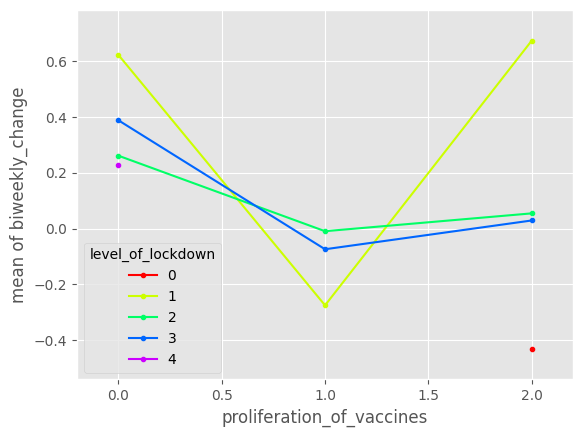

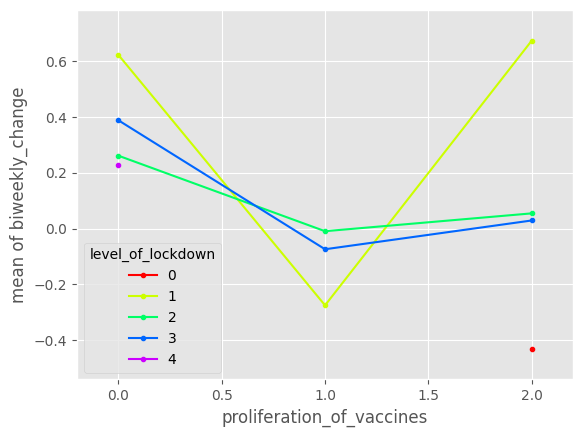

In [ ]:
interaction_plot(x=sdata['proliferation_of_vaccines'], trace=sdata['level_of_lockdown'], response=sdata['biweekly_change'])

### An interesting note that we can make using the graph is the fact the linesrepresenting the different levels of the factors cross each other. this could lead to the assumption that there are also interreaction betweeen the effect of the vaccines and the effect of lockdown.